# Selecting intracellular ions and creating a new METASPACE annotation database

v2.0 - [Changelog](changelog_create_database.md)

This notebook shows how to select intracellular metabolites from processed SpaceM data.
Ion-cell colocalization is quantified using either Spearman correlation or an area-**n**ormalized **M**anders **C**olocalization **C**oefficient (NMCC).  
Selected ions can be used to create a custom annotation database for use on METASPACE.

<div class="alert alert-info">
Before running this notebook, make sure to...  

- Install the [METASPACE Python client](https://pypi.org/project/metaspace2020/), [Scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) and [Outer SpaceM](https://mattausc.embl-community.io/outer-spacem/installation.html)
- [Create an API key for METASPACE](https://metaspace2020.eu/user/me)
- [Register your API key locally](https://metaspace2020.readthedocs.io/en/latest/content/examples/fetch-dataset-annotations.html#Connect-to-the-sm-server)  
<div class="alert alert-info">

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc
import outer_spacem as osm
import json

from scipy.stats import spearmanr
from metaspace import SMInstance

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

In [2]:
sns.set(
    rc={
        "figure.figsize":(7.5,7.5), 
        "legend.frameon": False
    },
    style="ticks",
    context="notebook"
)

### Setup

Quantification of ion-cell localization is done on the spatiomolecular matrices of **ablation marks** that are produced (i.e. the matrices stored in the `analysis/ablation_mark_analysis` directory, from here on called **AM matrix**).
For this example we're going to use the AM matrices of three SpaceM datasets.

From experience it makes close to no difference for ion selection whether ion-cell colocalization is evaluated on the combined datasets together, or separately and then aggregated. This notebook computes the scores separately and then aggregates them, so you can directly use the AM matrices produced by SpaceM.

In [55]:
# method used to filter the ions
selection_method = "nmcc" # "nmcc" or "spearman"
selection_threshold = 0.6
# Recommended for spearman: 0.1-0.2
# Recommended for nmcc: 0.6-0.7

# method to aggregate scores
aggregation_method = "mean" # "max" or "mean"

# optional: adducts to exclude from aggregation (without +/-)
exclude_adducts = [] # e.g. "Cl"

nonzero_threshold = 0.025 # Only include ions present in > 2.5% of pixels in >= 1 dataset(s). Set to 0 to disable.

#### Which selection method should I use?
- Use `'nmcc'` if you only need high precision for cells (i.e. metabolites should be exclusive to cells but do not need to be present in all cells in a dataset)
- Use `'spearman'` if you want your metabolites to have high precision *and* recall for cells (i.e. ions should be exclusive to cells and also present in all cells)

An ion's NMCC is defined as  
\begin{equation}
\frac{\text{on-sample ion counts}}{\text{on-sample ion counts + off-sample counts}} \cdot \frac{\text{off-sample area}}{\text{on-sample area}}
\end{equation}
Or, more precisely:
\begin{equation}
M = \frac{\sum_i I_i \cdot f_i}{\sum_i I_i \cdot f_i + \sum_i I_i \cdot (1-f_i)\cdot \frac{\overline{f}}{1 - \overline{f}}}
\end{equation}

Where $I_i$ is the ion's intensity and $f_i$ is ablation mark sampling ratio for pixel $i$.  
Essentially, it describes the fraction of ions that are on-sample when off- and on-sample areas are the same size. 
An NMCC of 0 therefore indicates that all ions are off-sample (i.e. exclusively extracellular), 0.5 indicates that ions are evenly distributed between on- and off-sample area, and 1 indicates that all ions are exclusively on-sample (i.e. intracellular).

#### Which aggregation method should I use?
This choice affects how scores are aggregated across datasets and adducts.  

- Use `'mean'` if you want to select metabolites that are consistently intracellular across datasets and adducts.
- Use `'max'` if you also want to select all metabolites that are intracellular _for at least one_ dataset and adduct, but may not be intracellular across all of them.

Note that any aggregation method will ignore scores from datasets where the ion is filtered out by the `nonzero_threshold` (see [below](#Filtering-out-low-abundance-ions)).

#### Excluding ions
Depending on experimental conditions you might want to exclude certain adducts from the scoring by adding them to `exclude_ions`.

#### Filtering out low-abundance ions
Low occurence ions have shown to have very little contribution to overall variance in SpaceM datasets and have close to zero impact on clusterings.  
Unless you specifically want to analyse these low-occurence ions, you can exclude them here from your database using the `nonzero_thresold` parameter. By default, only ions that are present in >2.5% of pixels in at least one dataset are included.
If you don't want to exclude low-abundance ions, set this parameter to 0.

### Loading the AM matrices

<div class="alert alert-warning">

Warning

As of Version 2.0, this notebook uses the AM matrices' **.h5ad** files, it no longer uses the .csv ones!

</div>

It is highly recommended you track all datasets within a SpaceM project in a central metadata table (e.g. a csv file or an Excel sheet), see [here](../sc_analysis/sc_analysis.ipynb#Loading-the-data) for a more detailed example explaining the benefits. 
Using a metadata table we can load the AM matrices like this:


In [56]:
metadata = pd.read_csv("/Users/alberto-mac/EMBL_ATeam/projects/gastrosome_compare_conditions/pixel_analysis/metaspace_datasets_paths.csv")

# Do some optional filtering:
# metadata = metadata[metadata.well == 4]
# metadata = metadata[metadata.slide == 6]
metadata


,datasetId,datasetName,condition,well,slide,group,submitter,PI,organism,organismPart,...,ionisationSource,maldiMatrix,analyzer,resPower400,polarity,uploadDateTime,FDR@10%,database,opticalImage,metaspace_download_dir_path
0,2021-10-27_00h20m47s,2021-28-09_Gastrosome_Slide6Drugs_Well8_150x15...,Drugs,8,6,♡EMBL♡,Mohammed Shahraz,Theodore Alexandrov,Homo sapiens (human) | Mus musculus (mouse),Cells,...,MALDI,DHB,Orbitrap,98995,positive,2021-10-26T18:20:47.944000,132,SwissLipids - 2018-02-02,https://metaspace2020.eu/fs/raw_optical_images...,/Users/alberto-mac/EMBL_ATeam/projects/gastros...
1,2021-10-27_00h05m07s,2021-28-09_Gastrosome_Slide5Feeding_Well3_150x...,Feeding,3,5,♡EMBL♡,Mohammed Shahraz,Theodore Alexandrov,Homo sapiens (human) | Mus musculus (mouse),Cells,...,MALDI,DHB,Orbitrap,98995,positive,2021-10-26T18:05:07.978000,107,SwissLipids - 2018-02-02,https://metaspace2020.eu/fs/raw_optical_images...,/Users/alberto-mac/EMBL_ATeam/projects/gastros...
2,2021-10-27_23h59m41s,2021-28-09_Gastrosome_Slide1control_well7_100x...,Control,7,1,♡EMBL♡,Mohammed Shahraz,Theodore Alexandrov,Homo sapiens (human) | Mus musculus (mouse),Cells,...,MALDI,DHB,Orbitrap,98995,positive,2021-10-27T23:59:41.744511,94,CoreMetabolome - v3,No optical image,/Users/alberto-mac/EMBL_ATeam/projects/gastros...
3,2021-10-27_23h59m25s,2021-28-09_Gastrosome_Slide1control_well8_100x...,Control,8,1,♡EMBL♡,Mohammed Shahraz,Theodore Alexandrov,Homo sapiens (human) | Mus musculus (mouse),Cells,...,MALDI,DHB,Orbitrap,98995,positive,2021-10-27T23:59:25.751249,113,SwissLipids - 2018-02-02,No optical image,/Users/alberto-mac/EMBL_ATeam/projects/gastros...
4,2021-10-27_00h32m38s,2021-28-09_Gastrosome_Slide1control_well4_150x...,Control,4,1,♡EMBL♡,Mohammed Shahraz,Theodore Alexandrov,Homo sapiens (human) | Mus musculus (mouse),Cells,...,MALDI,DHB,Orbitrap,98995,positive,2021-10-27T00:32:39.557240,148,SwissLipids - 2018-02-02,No optical image,/Users/alberto-mac/EMBL_ATeam/projects/gastros...
5,2021-10-27_00h20m58s,2021-28-09_Gastrosome_Slide6Drugs_Well4_150x15...,Drugs,4,6,♡EMBL♡,Mohammed Shahraz,Theodore Alexandrov,Homo sapiens (human) | Mus musculus (mouse),Cells,...,MALDI,DHB,Orbitrap,98995,positive,2021-10-27T00:20:59.427535,74,CoreMetabolome - v3,No optical image,/Users/alberto-mac/EMBL_ATeam/projects/gastros...
6,2021-10-27_00h16m49s,2021-28-09_Gastrosome_Slide6Drugs_Well3_150x15...,Drugs,3,6,♡EMBL♡,Mohammed Shahraz,Theodore Alexandrov,Homo sapiens (human) | Mus musculus (mouse),Cells,...,MALDI,DHB,Orbitrap,98995,positive,2021-10-27T00:16:49.937781,34,CoreMetabolome - v3,No optical image,/Users/alberto-mac/EMBL_ATeam/projects/gastros...
7,2021-10-27_00h09m40s,2021-28-09_Gastrosome_Slide5Feeding_Well8_150x...,Feeding,8,5,♡EMBL♡,Mohammed Shahraz,Theodore Alexandrov,Homo sapiens (human) | Mus musculus (mouse),Cells,...,MALDI,DHB,Orbitrap,98995,positive,2021-10-27T00:09:40.949112,93,SwissLipids - 2018-02-02,No optical image,/Users/alberto-mac/EMBL_ATeam/projects/gastros...
8,2021-10-27_00h03m04s,2021-28-09_Gastrosome_Slide5Feeding_Well7_150x...,Feeding,7,5,♡EMBL♡,Mohammed Shahraz,Theodore Alexandrov,Homo sapiens (human) | Mus musculus (mouse),Cells,...,MALDI,DHB,Orbitrap,98995,positive,2021-10-27T00:03:04.917123,69,SwissLipids - 2018-02-02,No optical image,/Users/alberto-mac/EMBL_ATeam/projects/gastros...
9,2021-10-26_23h23m07s,2021-28-09_Gastrosome_Slide1control_well3_100x...,Control,3,1,♡EMBL♡,Mohammed Shahraz,Theodore Alexandrov,Homo sapiens (human) | Mus musculus (mouse),Cells,...,MALDI,DHB,Orbitrap,98995,positive,2021-10-26T23:23:07.395537,65,SwissLipids - 2018-02-02,No optical image,/Users/alberto-mac/EMBL_ATeam/projects/gastros...


In [57]:
pattern = "/Users/alberto-mac/EMBL_ATeam/projects/gastrosome_compare_conditions/pixel_analysis/metaspace_data/slide_{slide}/W{well}/adata.h5ad"



Alternatively, you can also simply supply a list of paths, for this check out [Outer Spacem's documentation](https://mattausc.embl-community.io/outer-spacem/outer_spacem.io.html#outer_spacem.io.bulk_read)

<div class="alert alert-info">

Note

Remember to provide the paths to the **ablation mark** matrices (located at `<dataset root>/analysis/ablation_mark_analysis`), not the cell matrices!

</div>

In [58]:
am_matrix = osm.io.bulk_read(metadata, file_pattern=pattern, join="outer", fill_value=0)

print(f"Read {len(metadata)} datasets containing {am_matrix.n_vars} unique ion annotations for {am_matrix.n_obs} pixels.")

100%|██████████| 11/11 [00:01<00:00, 10.51it/s]


Read 11 datasets containing 1680 unique ion annotations for 210000 pixels.


In [59]:
dataset_path = "/Users/alberto-mac/EMBL_ATeam/projects/gastrosome/Drug_W8/initial_processing/ablation_mark_analysis/spatiomolecular_adata.h5ad"
# dataset_path = "/Users/alberto-mac/EMBL_ATeam/projects/gastrosome/Feeding_W3/initial_processing/ablation_mark_analysis/spatiomolecular_adata.h5ad"

am_matrix = sc.read(dataset_path)

In [60]:
am_matrix.X.shape

(22500, 866)

### Evaluate ion-cell colocalization

In [61]:
def nmcc(I, f):
    f_ = f.mean()
    I_on = np.sum(I * f)
    I_off = np.sum(I * (1 - f) * (f_ / (1 - f_)))
    return I_on / (I_on + I_off)

In [62]:
scores = []

for dataset, ds_amm in osm.tl.groupby(am_matrix, "dataset"):
    # filter low-abundance ions
    ds_amm_filt = ds_amm[:, (ds_amm.X != 0).mean(axis=0) > nonzero_threshold].copy()
    ds_scores = pd.DataFrame(
        {
            "dataset": dataset,
            "ion": ds_amm_filt.var.index,
            "spearman": np.apply_along_axis(spearmanr, 0, ds_amm_filt.X, ds_amm_filt.obs.am_sampling_ratio)[0],
            "nmcc": np.apply_along_axis(nmcc, 0, ds_amm_filt.X, ds_amm_filt.obs.am_sampling_ratio)
        }
    )

    scores.append(ds_scores)

scores = pd.concat(scores, ignore_index=True)
scores[["formula","adduct"]] = scores["ion"].str.split("[+-]", regex=True, expand=True)
scores_agg = scores[~scores.adduct.isin(exclude_adducts)].groupby(["formula"])[["spearman", "nmcc"]].agg(["mean", "max"])

Once we have computed the scores, we can take a closer look at the distribution of per-ion scores for both spearman correlation and NMCC:

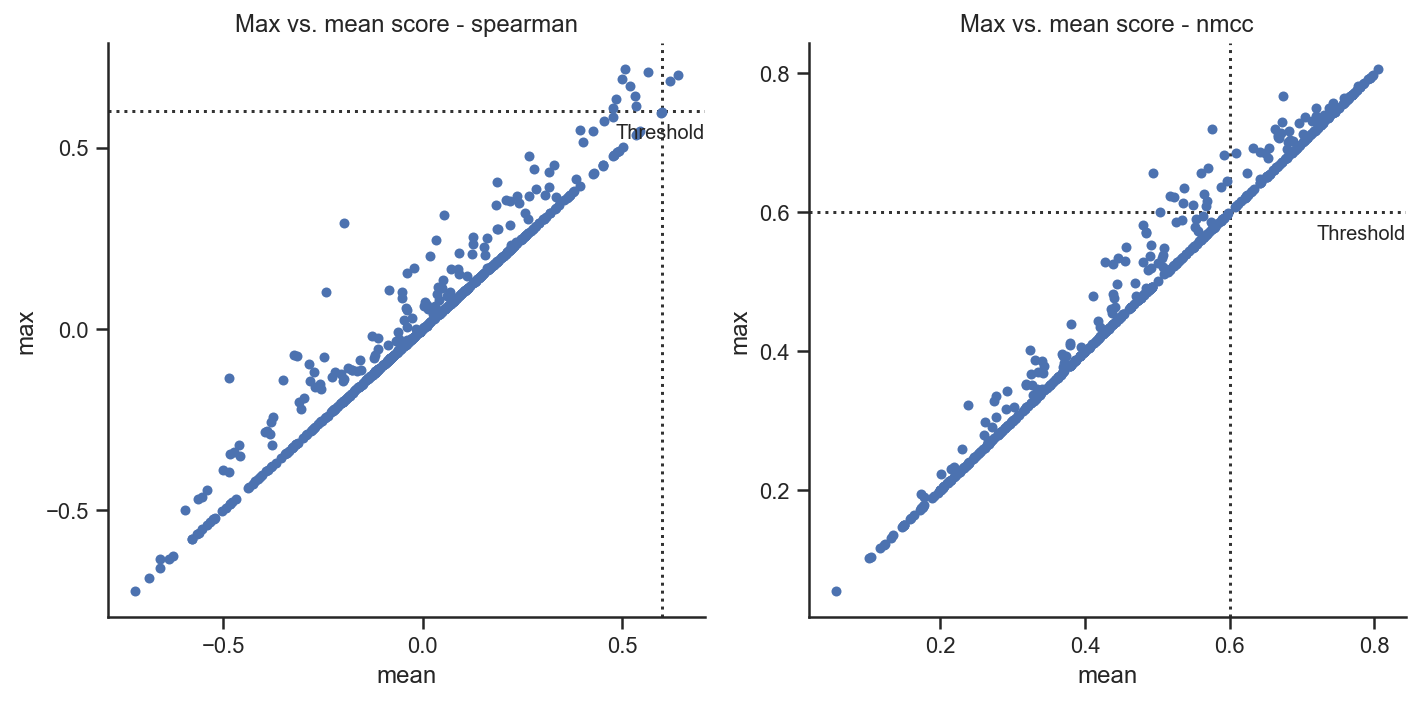

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False)

for metric, ax in zip(["spearman", "nmcc"], axes):

    scores_metric = scores_agg[metric].copy()

    plt.sca(ax)
    sns.scatterplot(
        data=scores_metric,
        x="mean",
        y="max",
        linewidth=0,
        s=25
    )
    plt.title(f"Max vs. mean score - {metric}")
    sns.despine()
    plt.locator_params(nbins=5)
    ax.axhline(y=selection_threshold, c=".2", linestyle=":", zorder=0)
    ax.axvline(x=selection_threshold, c=".2", linestyle=":", zorder=0)
    ax.text(
        s="Threshold", 
        y=selection_threshold - np.ptp(ax.get_ylim())*0.02, 
        x=ax.get_xlim()[1], 
        fontsize=10, 
        va="top",
        ha="right"
    )

plt.tight_layout()
plt.show()

Comparison of aggregated per-metabolite scores for both spearman correlation and NMCC.  
Note that not all metabolites selected by their max score would also be selected by their mean value.

In [64]:
scores_agg = scores_agg.loc[:, scores_agg.columns.get_level_values(1)==aggregation_method].copy()
scores_agg.columns = scores_agg.columns.droplevel(1)
scores_agg["selected"] = scores_agg[selection_method] > selection_threshold

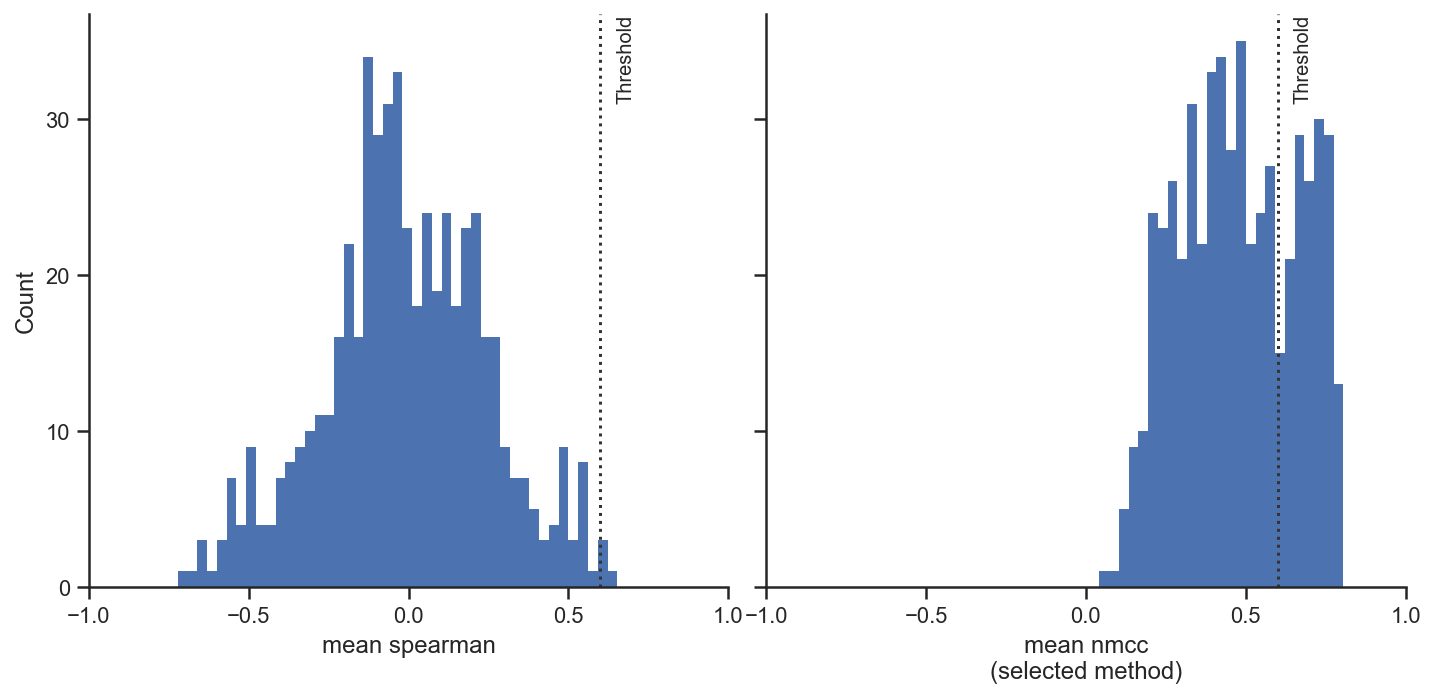

In [65]:
g = sns.displot(
    scores_agg.melt(value_vars = ["spearman", "nmcc"]),
    x="value",
    col="variable",
    kind="hist",
    bins=50,
    fill=True,
    linewidth=0,
    alpha=1
)

g.set_titles("")

for ax, title in zip(g.axes.flatten(), g.col_names):
    ax.axvline(x=selection_threshold, c=".2", linestyle=":")
    ax.text(
        s="Threshold", 
        x=selection_threshold+0.05, 
        y=plt.ylim()[1], 
        fontsize=10, 
        va="top",
        rotation=90
    )
    if title == selection_method:
        ax.set_xlabel(f"{aggregation_method} {title}\n(selected method)")
    else:
        ax.set_xlabel(f"{aggregation_method} {title}")

plt.xlim(-1, 1)
plt.locator_params(nbins=4) 
plt.show()


Distribution of aggregated per-metabolite scores for both Spearman correlation and NMCC.  
Metabolites for which the selected score is above the selection threshold will be included in your custom database.

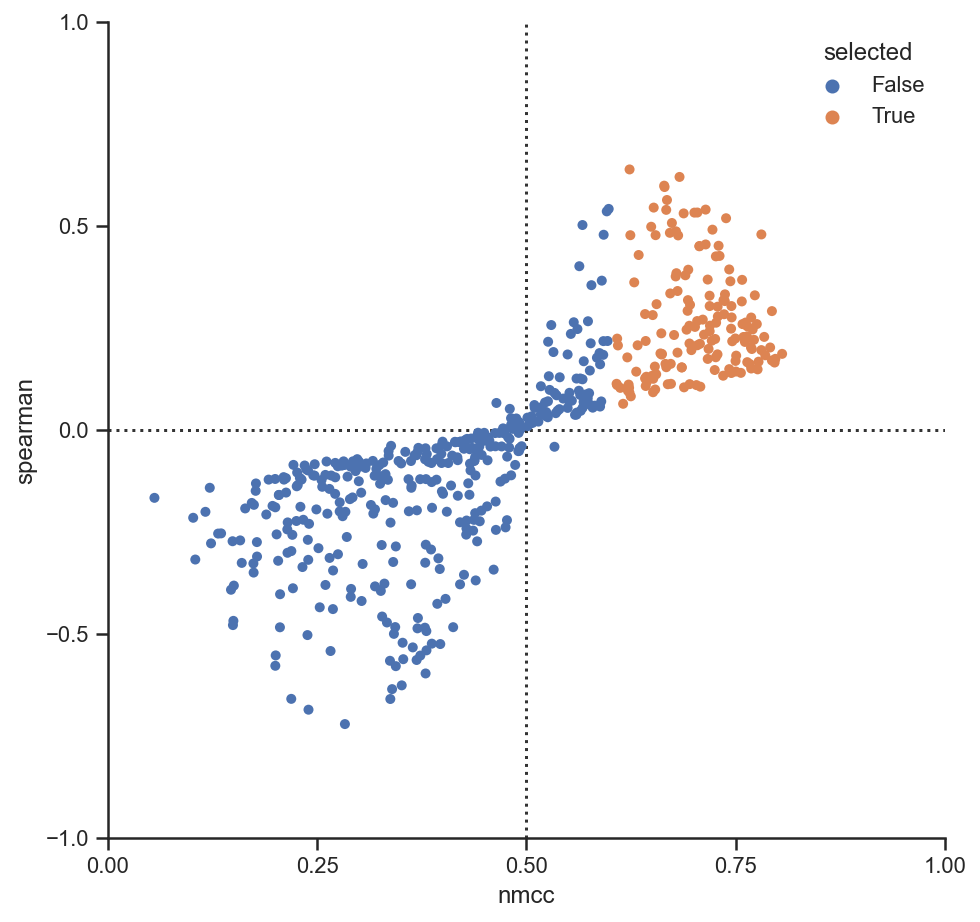

In [66]:
sns.scatterplot(
    data=scores_agg,
    x="nmcc",
    y="spearman",
    linewidth=0,
    hue="selected",
    s=25
)

plt.axhline(y=0, c=".2", linestyle=":", zorder=0)
plt.axvline(x=0.5, c=".2", linestyle=":", zorder=0)

plt.xlim([0, 1])
plt.ylim([-1, 1])

plt.locator_params(nbins=4)
sns.despine()
plt.show()

Note that the two different scores are are not proportional, therefore depending on the chosen method you may select different ions.   

### Create & upload new database

In [67]:
selected_metabolites = scores_agg[
    scores_agg["selected"]
].index

print(f"Selected {selected_metabolites.size} metabolites.")

Selected 157 metabolites.


#### Map sum formulas to molecule names

In [68]:
var = am_matrix.var.copy()
var.index = var.index.str.replace("[+-].*", "", regex=True)
var = var.loc[selected_metabolites] # Subset to selected metabolites

var = var.filter(regex=r"moleculeNames") # Select all 'moleculeNames' columns
var = var.applymap(json.loads, na_action="ignore") # Parse json into Python lists

# Gather molecule names across datasets (and databases)
var = var.apply(
    lambda x: np.unique(
        np.array(
            x.dropna().tolist(), 
            dtype=object
            )
        ), 
    axis=1
)

var = var.drop_duplicates()
var = var.explode()

db_df = var.reset_index(name="name")
db_df.index = pd.RangeIndex(start=1, stop=len(db_df) + 1, name="id")

print(f"Mapped {selected_metabolites.size} sum formulas to {len(db_df)} molecule names.")

Mapped 157 sum formulas to 5082 molecule names.


#### Uploading to METASPACE

An easy way to now restrict your single-cell analysis to intrallular ions is to exclude all ions that are not part of `database_df`. An even better way however is to use this list of ions and turn it into a custom database for METASPACE and reannotate your datasets, as using a custom database will also combat the issue of missing values due to METASPACE's FDR threshold.

To create a custom database, you're going to need a name and a version number:

In [69]:
# db_name = "Gastrosome_FeedingW3_intra_ions"
# db_version = "v3"
db_name = "Gastrosome_pixel_analysis_intra_ions"
db_version = "v1"

import os
out_folder = "/Users/alberto-mac/EMBL_ATeam/projects/gastrosome_compare_conditions/pixel_analysis"

db_filename = f"AB_{db_name}_{db_version}.tsv" # XY = ideally your initials for easier handling on METASPACE

db_filename = os.path.join(out_folder, db_filename)


In [70]:
db_df.to_csv(
    db_filename, sep="\t", index=True
)

Once we have the database file, we can upload it to METASPACE:

In [71]:
sm = SMInstance()

In [72]:
upload_result = sm.create_database(
    local_path=db_filename,
    name=db_name,
    version=db_version,
    is_public=False,
)

upload_result

Uploading part   1/  1 of AB_Gastrosome_pixel_analysis_intra_ions_v1.tsv file...


{'id': 552}

This chunk of code will create the database and return a number corresponding to your database's ID.  
**Write it down** and continue with the [reannotation notebook](bulk_reannotation.ipynb) to reannotate your datasets against the new database.

#### Saving separate scores
Just in case you want to want to incorporate this information at a later point, consider also saving the unaggregates scores:

In [20]:
scores.to_csv("raw_scores.tsv", sep='\t')